In [1]:
#| hide
# what


# Single-Cell-Fuzzy-Labels


![Single-Cell Fuzzy Labels Concept](https://raw.githubusercontent.com/Eamonmca/Single-Cell-Fuzzy-Labels/master/Single_Cell_Fuzzy_Labels/logo.png)


## Install

 ```sh
git clone https://github.com/Eamonmca/Single-Cell-Fuzzy-Labels
cd Single-Cell-Fuzzy-Labels
pip install .
 ```


## How to use


In this notebook, we are demonstrating the use of the `Single_Cell_Fuzzy_Labels` library. This library is designed to facilitate the transfer of labels from a well-annotated reference dataset to a query dataset in single-cell RNA sequencing (scRNA-seq) studies. The library provides functions for label transfer, visualization of label transfers, and harmonization of cell labels.

The process begins with the extraction of Universal Cell Embeddings (UCE) from both the reference and query datasets. The UCE is a lower-dimensional representation of the datasets that is used for label transfer.

The `transfer.labels` function is then used to perform the label transfer. This function takes several parameters including the UCE of the reference and query datasets, the labels from the reference dataset that we want to transfer, and the number of nearest neighbors to consider when transferring labels.

After the label transfer, the `viz` module is used to visualize the label transfers and the distribution of the transferred labels. This helps in understanding how well the labels from the reference dataset map to the cells in the query dataset.

Finally, the `harmonise` module is used to match the cell labels in the query dataset with those in the reference dataset. This is done by creating a dictionary that maps each unique label in the query dataset to a corresponding label in the reference dataset. We leverage the reasoning capabilitys of GPT-4 to do this using the openAI API.


In [2]:
from Single_Cell_Fuzzy_Labels import census
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
from dotenv import load_dotenv
load_dotenv()
warnings.filterwarnings('ignore')



In the following section, we will be loading the reference dataset. This dataset is a pre-embedded data from the cellxgene census, which contains a vast dataset of 33 million cells. We will be using the 'homo_sapiens' organism and 'lung' tissue for this example. The data is loaded using the 'read_h5ad' function from the 'scanpy' library. 

After loading the data, we will subset it to only include 'Epithelial' cells. This is done by filtering the 'ann_level_1' column of the 'obs' attribute of the 'reference' object. The subset is then assigned back to the 'reference' object.

We will then display the 'X_uce' attribute of the 'obsm' attribute of the 'reference' object. This attribute contains the Universal Cell Embeddings for the 'reference' object.


In [3]:
# reference = census.download_emb(organism='homo_sapiens', tissue='lung', test = True)
reference = sc.read_h5ad('/data/analysis/data_mcandrew/000-sc-UCA-test/uce/HCA_lung_core__uce_adata.h5ad')

In [4]:
reference

AnnData object with n_obs × n_vars = 584944 × 18166
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

In [5]:
reference_subset = reference[reference.obs['ann_level_1'] == 'Epithelial']

In [6]:
reference = reference_subset

In [7]:
reference.obsm['X_uce']

ArrayView([[ 0.00750788, -0.04194154,  0.00931572, ...,  0.03899895,
            -0.02080086, -0.01758753],
           [ 0.02603231,  0.03415936, -0.00083805, ...,  0.01040316,
             0.00231683,  0.07622543],
           [ 0.01907516, -0.03912187,  0.01917193, ...,  0.02607882,
             0.02887304, -0.00058624],
           ...,
           [ 0.00766119, -0.03144012,  0.00277021, ...,  0.03181685,
             0.00958184,  0.01409992],
           [-0.0129706 ,  0.04543586, -0.00394633, ..., -0.01092251,
             0.01244534,  0.01408385],
           [-0.0060271 ,  0.00604395,  0.01479142, ..., -0.00512656,
            -0.01186521,  0.02647699]], dtype=float32)

 Now, we will import our query dataset. This dataset has been preprocessed and the embeddings have been precomputed using the instructions provided on the Universal Cell Embeddings (UCE) GitHub page.  Next, we will leverage our well-annotated reference dataset to predict the labels in our query dataset. This process is crucial as it allows us to infer the cell types in the query dataset based on the known labels in the reference dataset. This is achieved by comparing the embeddings of cells in both datasets and assigning the labels from the nearest neighbors in the reference dataset to the cells in the query dataset. The Single_Cell_Fuzzy_Labels library provides an efficient and accurate method for this label transfer process.


In [8]:
query = sc.read_h5ad('/data/analysis/data_mcandrew/000-sc-UCA-test/uce/HBECS_ALI28_uce_adata.h5ad')

In [9]:
query

AnnData object with n_obs × n_vars = 10224 × 14949
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mito', 'percent.ribo', 'dropouts', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.4', 'seurat_clusters', 'echantillon', 'donor', 'medium', 'sample', 'type', 'batch', 'type_pred', 'type_uncertainty', 'leiden', 'RNA_snn_res.1', 'cluster_l1', 'celltype_l1', 'ident', 'n_genes'
    var: 'n_cells'
    uns: 'X_name'
    obsm: 'SCANVI', 'UMAP', 'X_uce'
    layers: 'logcounts'

In [10]:
query.obsm['X_uce']

array([[ 0.0045417 , -0.0086563 ,  0.01687446, ...,  0.02272223,
        -0.01826951, -0.01024585],
       [ 0.01364084, -0.00542254,  0.01779299, ...,  0.01887637,
        -0.00538362,  0.00553044],
       [ 0.00350829,  0.01183089,  0.01040006, ...,  0.01037928,
        -0.01872197, -0.01138068],
       ...,
       [-0.00063122, -0.01984753,  0.02148496, ...,  0.00014579,
         0.01573275, -0.00872346],
       [ 0.00331486, -0.00467246, -0.02007541, ...,  0.01982483,
         0.00755446,  0.00302285],
       [-0.00757075,  0.01373623,  0.01243316, ...,  0.03014414,
        -0.01670015, -0.01620588]], dtype=float32)

In [11]:
from Single_Cell_Fuzzy_Labels import transfer 

In this step, we perform the label transfer using the 'transfer.labels' function from the Single_Cell_Fuzzy_Labels library. This function takes in the embeddings of the reference and query datasets, the labels of the reference dataset, and several other parameters to control the label transfer process. The function uses a nearest neighbors approach to assign labels from the reference dataset to the query dataset. This is a crucial step in our analysis as it allows us to infer the cell types in the query dataset based on the known labels in the reference dataset.


In [12]:
predicted_labels = transfer.labels(embedding_array_reference=reference.obsm['X_uce'], 
                          embedding_array_query=query.obsm['X_uce'], 
                          reference_labels=reference.obs['ann_finest_level'], 
                          k=1, 
                          use_gpu=True, 
                          batch_size=None, 
                          distance_metric='L2', 
                          label_consensus='centroid_based', 
                          timed=False)

In [13]:
query.obs['predicted_labels'] = predicted_labels

In [14]:
query.obs['celltype_l1'].head(10)


Donor1_ALI28_AAACCTGAGCCACCTG    Suprabasal
Donor1_ALI28_AAACCTGAGCTCAACT         Basal
Donor1_ALI28_AAACCTGAGTAAGTAC         Basal
Donor1_ALI28_AAACCTGCAAACCCAT         Basal
Donor1_ALI28_AAACCTGGTCCTAGCG     Secretory
Donor1_ALI28_AAACCTGGTCTCGTTC        Goblet
Donor1_ALI28_AAACCTGTCATACGGT    Suprabasal
Donor1_ALI28_AAACCTGTCCATGAGT     Secretory
Donor1_ALI28_AAACCTGTCCGCGTTT         Basal
Donor1_ALI28_AAACGGGAGAGTAATC     Secretory
Name: celltype_l1, dtype: category
Categories (9, object): ['Basal', 'Cycling Basal', 'Deuterosomal', 'Multiciliated', ..., 'Squamous', 'Secretory', 'Goblet', 'Rare cells']

In [15]:
predicted_labels[:10]

['Basal resting',
 'Basal resting',
 'Club (nasal)',
 'Basal resting',
 'Club (non-nasal)',
 'Goblet (nasal)',
 'Club (nasal)',
 'Suprabasal',
 'Basal resting',
 'Club (nasal)']

In [16]:
from Single_Cell_Fuzzy_Labels import viz 

In [17]:
transfers = viz.map_label_transfers(query, 'predicted_labels', 'celltype_l1')

In [18]:
print(transfers.head(10))

celltype_l1               Basal  Cycling Basal  Deuterosomal  Multiciliated  \
predicted_labels                                                              
Basal resting          0.823691       0.125148      0.000000       0.001574   
Club (nasal)           0.100762       0.021675      0.002343       0.000000   
Club (non-nasal)       0.003484       0.000581      0.002904       0.000000   
Deuterosomal           0.037838       0.000000      0.621622       0.275676   
Goblet (bronchial)     0.000000       0.000000      0.000000       0.000000   
Goblet (nasal)         0.011701       0.000900      0.009901       0.000900   
Goblet (subsegmental)  0.000000       0.000000      0.000000       0.000000   
Hillock-like           0.555556       0.157233      0.000000       0.000000   
Ionocyte               0.200000       0.000000      0.000000       0.000000   
Multiciliated (nasal)  0.000000       0.000000      0.000000       1.000000   

celltype_l1            Suprabasal  Squamous  Secret

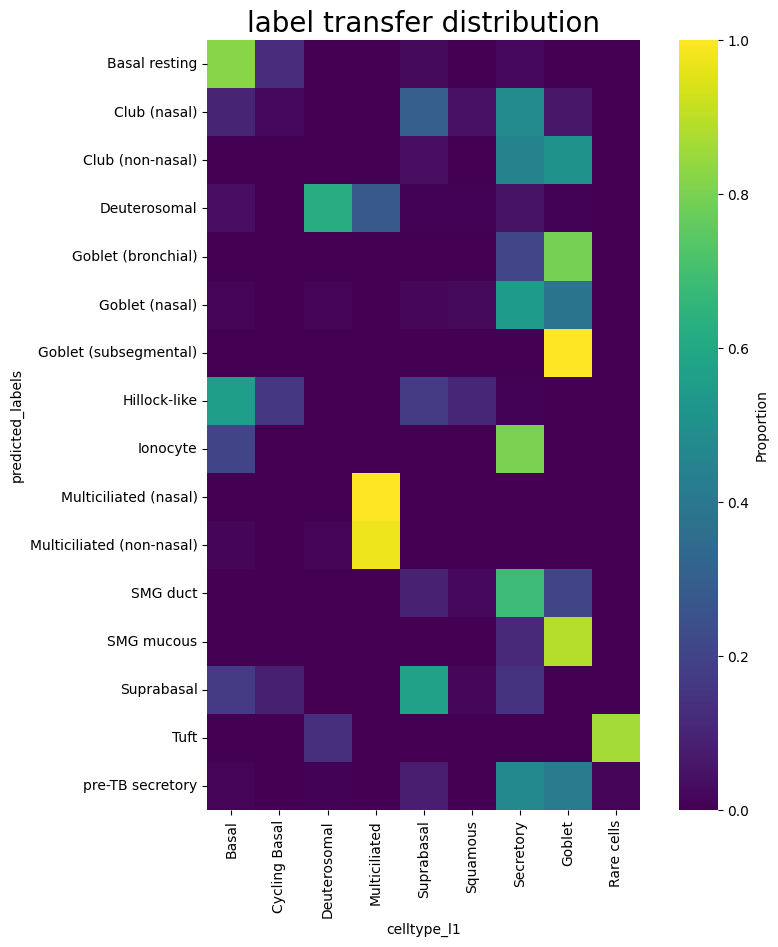

In [19]:
viz.visualize_label_distribution(transfers, fuzz1_score=None, title='label transfer distribution')
plt.show()

In single cell data analysis, a common issue arises when dealing with annotations such as cell types. Even for identical cells, the annotation sets may not match perfectly. This discrepancy can be due to various factors such as differences in annotation methods, experimental conditions, or even biological variability. This inconsistency poses a significant challenge in integrating and comparing single cell datasets across different studies or conditions. 

Single-Cell-Fuzzy-Labels, provides a solution to this problem. It uses a fuzzy labeling approach to harmonize the cell type annotations across different datasets. The library leverages the power of natural language processing and reasoning capabilities of GPT-4 to match the cell type labels. It also provides visualization tools to inspect the label transfers and the distribution of labels. 


In [20]:
from Single_Cell_Fuzzy_Labels import harmonise 


In [21]:
Label_alias_dict = harmonise.match_cell_labels(list(query.obs['celltype_l1'].values.unique()), list(query.obs['predicted_labels'].unique()))

In [22]:
query.obs['celltype_l1'].unique()

['Suprabasal', 'Basal', 'Secretory', 'Goblet', 'Deuterosomal', 'Multiciliated', 'Cycling Basal', 'Squamous', 'Rare cells']
Categories (9, object): ['Basal', 'Cycling Basal', 'Deuterosomal', 'Multiciliated', ..., 'Squamous', 'Secretory', 'Goblet', 'Rare cells']

In [23]:
print(query.obs['predicted_labels'].values[:10])


['Basal resting' 'Basal resting' 'Club (nasal)' 'Basal resting'
 'Club (non-nasal)' 'Goblet (nasal)' 'Club (nasal)' 'Suprabasal'
 'Basal resting' 'Club (nasal)']


In [24]:
Label_alias_dict

{'Basal resting': 'Basal',
 'Club (nasal)': 'Secretory',
 'Club (non-nasal)': 'Secretory',
 'Goblet (nasal)': 'Goblet',
 'Suprabasal': 'Suprabasal',
 'Deuterosomal': 'Deuterosomal',
 'Multiciliated (non-nasal)': 'Multiciliated',
 'Hillock-like': 'Rare cells',
 'pre-TB secretory': 'Secretory',
 'SMG mucous': 'Goblet',
 'Tuft': 'Rare cells',
 'Goblet (subsegmental)': 'Goblet',
 'SMG duct': 'Secretory',
 'Ionocyte': 'Rare cells',
 'Multiciliated (nasal)': 'Multiciliated',
 'Goblet (bronchial)': 'Goblet'}

In this section, we will utilize the 'harmonise' function from the Single-Cell-Fuzzy-Labels library. This function is designed to address the common issue in single cell data analysis where identical cells may have different annotations due to various factors such as differences in annotation methods, experimental conditions, or biological variability. The 'harmonise' function uses a fuzzy labeling approach to match cell type labels across different datasets, thereby enabling more accurate integration and comparison of single cell datasets from different studies or conditions. 


In [25]:
query.obs['mapped_predictions'] = harmonise.map_old_labels_to_new(list(query.obs['predicted_labels'].values), Label_alias_dict)

Additionally, we will calculate a 'fuzz_1' score. This score is a measure of the effectiveness of our fuzzy labeling approach in matching cell type labels across different datasets. It will provide us with a (semi) quantitative assessment of the harmonization process, complementing our visual analysis.


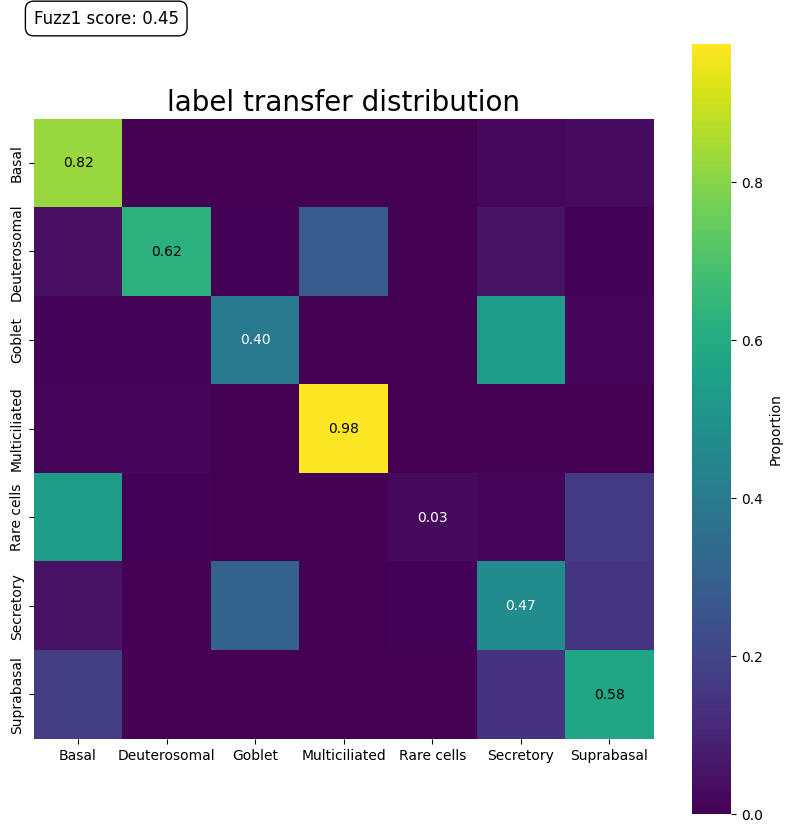

In [26]:
fuzz_1 = viz.calculate_fuzz_1(query, reference_label='celltype_l1', predicted_query_label='mapped_predictions')
transfers = viz.map_label_transfers(query, 'mapped_predictions', 'celltype_l1')
viz.visualize_label_distribution(transfers, fuzz1_score=fuzz_1, title='label transfer distribution', proportions_flag = 'md', matched = True)
plt.show()

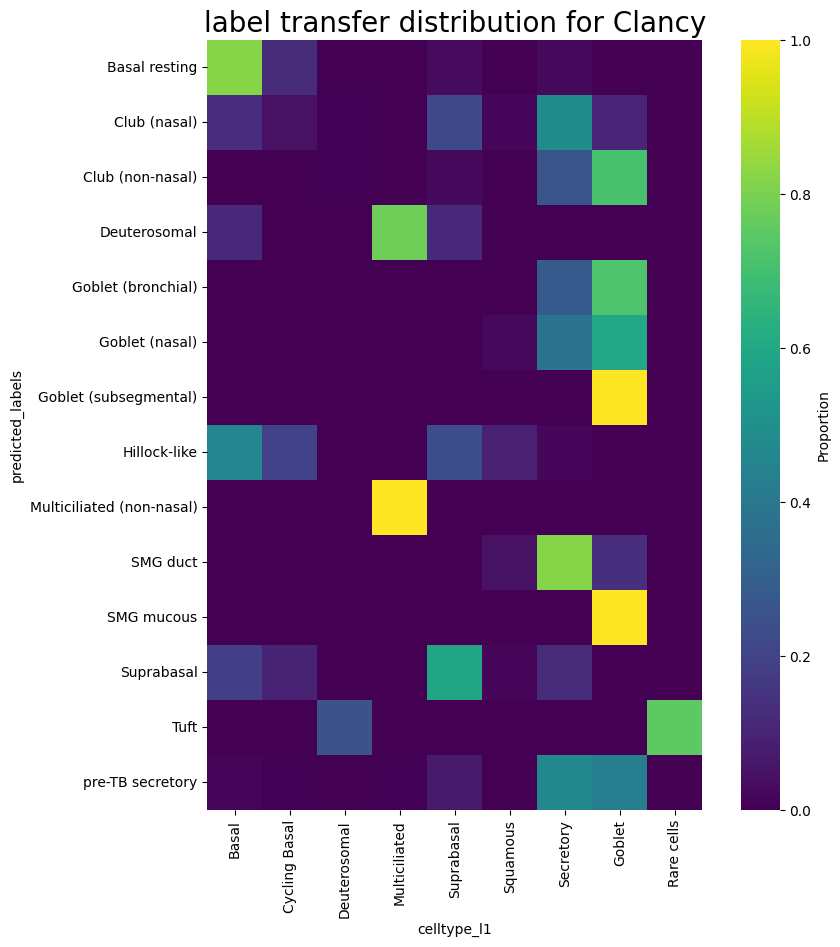

<Figure size 640x480 with 0 Axes>

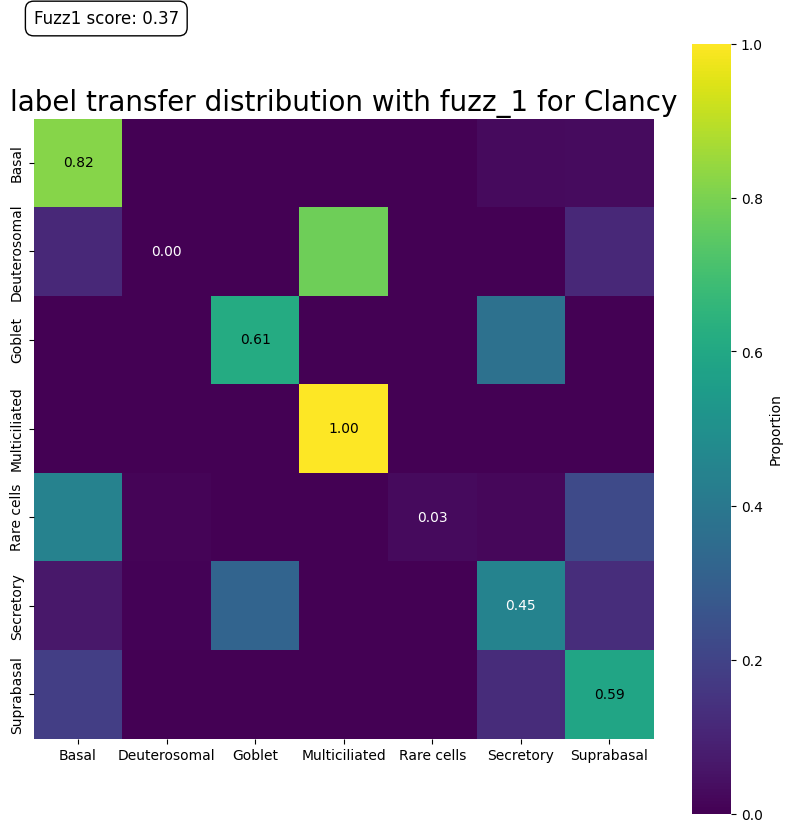

<Figure size 640x480 with 0 Axes>

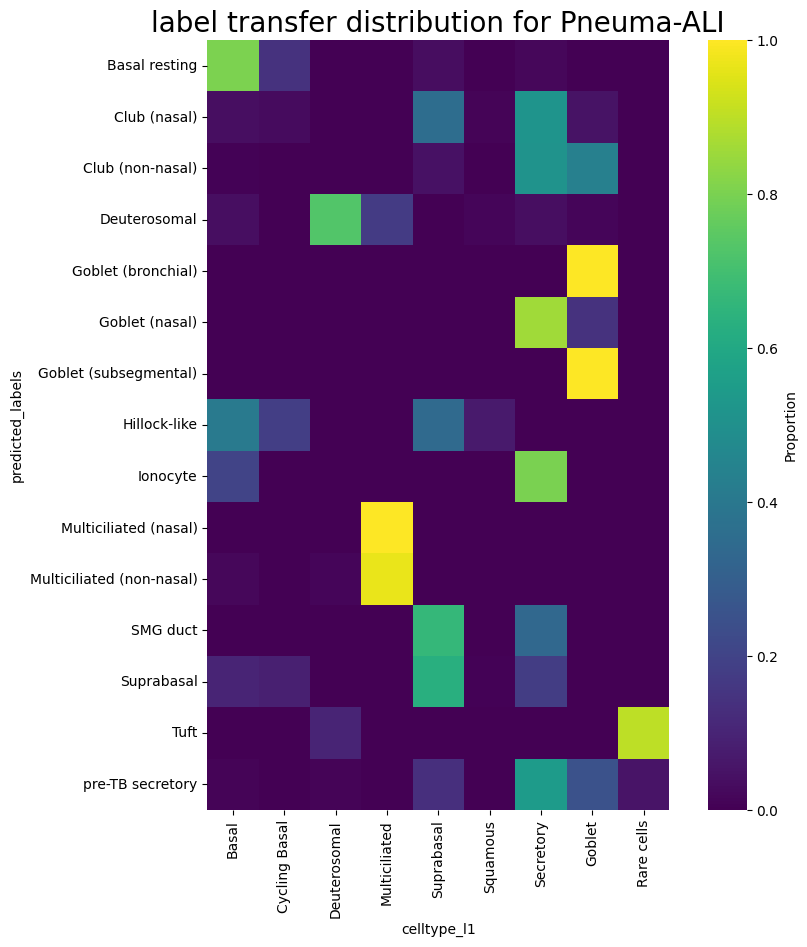

<Figure size 640x480 with 0 Axes>

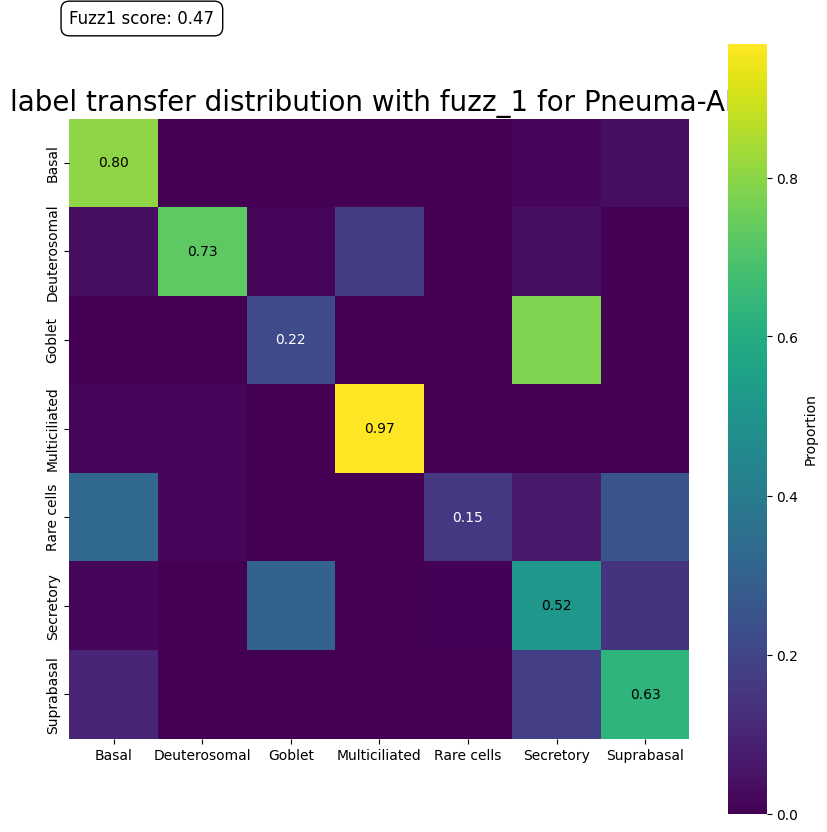

<Figure size 640x480 with 0 Axes>

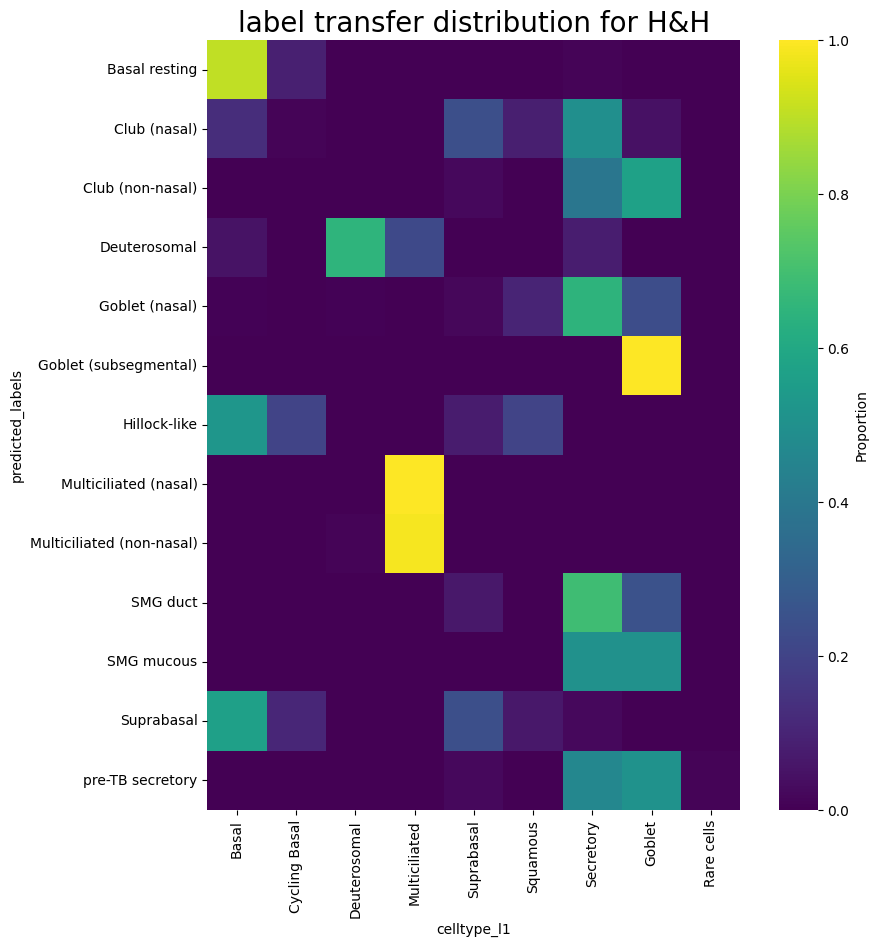

<Figure size 640x480 with 0 Axes>

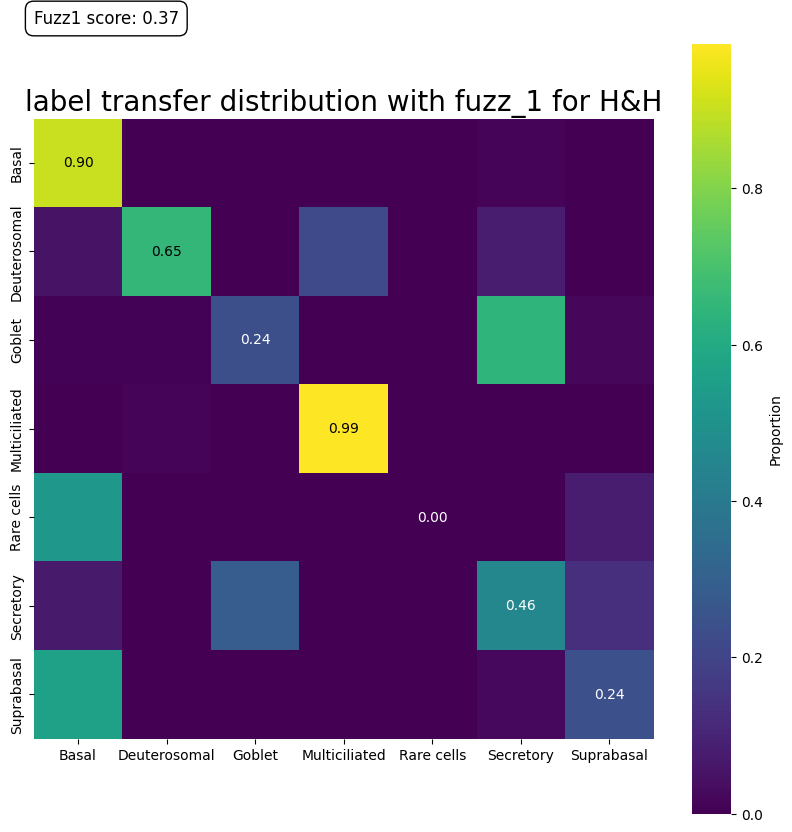

<Figure size 640x480 with 0 Axes>

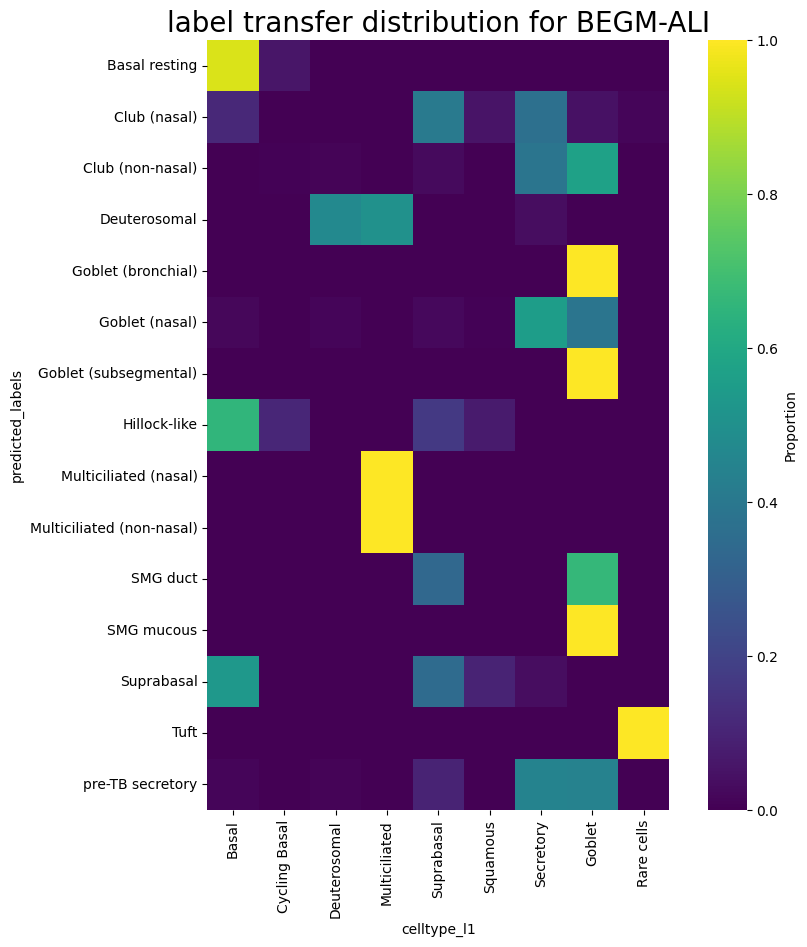

<Figure size 640x480 with 0 Axes>

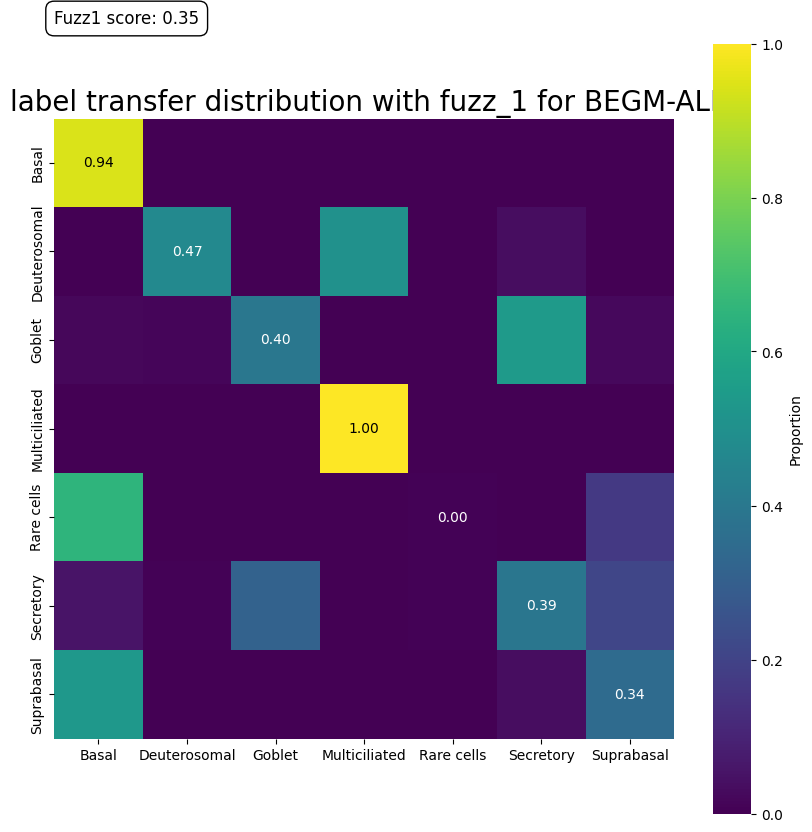

<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt

medium_list = query.obs['medium'].unique().tolist()
for medium in medium_list:
    medium_subset = query[query.obs['medium'] == medium]
    transfers = viz.map_label_transfers(medium_subset, 'predicted_labels', 'celltype_l1')
    viz.visualize_label_distribution(transfers, fuzz1_score=None, title=f'label transfer distribution {medium}')
      
    plt.tight_layout()
    plt.show()
    
    fuzz_1 = viz.calculate_fuzz_1(medium_subset, reference_label='celltype_l1', predicted_query_label='mapped_predictions')
    transfers = viz.map_label_transfers(medium_subset, 'mapped_predictions', 'celltype_l1')
    

    viz.visualize_label_distribution(transfers, fuzz1_score=fuzz_1, title=f'label transfer distribution fuzz_1 {medium}', proportions_flag = 'md', matched = True)
    
    plt.tight_layout()
    plt.show()
